In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns



def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/Colab Notebooks/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/Colab Notebooks/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

from sklearn.model_selection import train_test_split

X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)

X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape

/tmp/ipython-input-272149219.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-272149219.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-272149219.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-272149219.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

In [3]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

## Simple CNN Model

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

# 입력: (128, 9), 출력: 6 classes
input_shape = (128, 9)
num_classes = 6

simple_cnn_model = Sequential([
    # 첫 번째 Conv 블록
    Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    # 두 번째 Conv 블록
    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    # 평탄화 후 Dense 연결
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    # 출력층
    Dense(num_classes, activation='softmax')
])

# 모델 컴파일
simple_cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 모델 요약
simple_cnn_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 126, 64)        │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 61, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3840)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       491,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 519,686 (1.98 MB)

 Trainable params: 519,302 (1.98 MB)

 Non-trainable params: 384 (1.50 KB)

In [5]:
history = simple_cnn_model.fit(
    X_train, y_train_one_hot,
    epochs=30,
    batch_size=64,
    validation_data=(X_val, y_val_one_hot)
)


Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.7393 - loss: 0.9705 - val_accuracy: 0.1720 - val_loss: 3.3968
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9241 - loss: 0.2055 - val_accuracy: 0.3100 - val_loss: 4.5982
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9334 - loss: 0.1718 - val_accuracy: 0.5275 - val_loss: 2.5646
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9458 - loss: 0.1411 - val_accuracy: 0.7464 - val_loss: 0.8775
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9494 - loss: 0.1435 - val_accuracy: 0.9286 - val_loss: 0.1555
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9460 - loss: 0.1500 - val_accuracy: 0.9483 - val_loss: 0.1406
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9415 - loss: 0.1485 - val_accuracy: 0.9429 - val_loss: 0.1270
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9480 - loss: 0.1203 - val_accuracy: 0.9483 - v

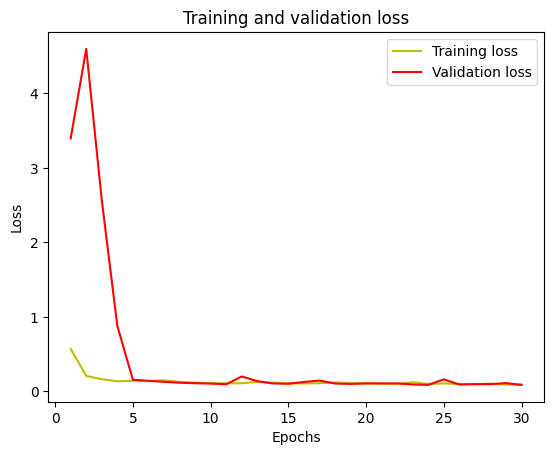

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

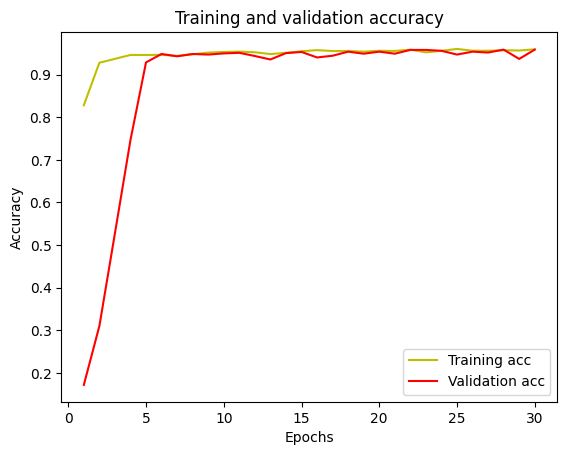

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

 1/93 ━━━━━━━━━━━━━━━━━━━━ 17s 195ms/step

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=('Tensor(shape=(32, 128, 9))', 'Tensor(shape=(32, 128, 9))', 'Tensor(shape=(32, 128, 9))', 'Tensor(shape=(32, 128, 9))')
  warnings.warn(msg)


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=('Tensor(shape=(None, 128, 9))', 'Tensor(shape=(None, 128, 9))', 'Tensor(shape=(None, 128, 9))', 'Tensor(shape=(None, 128, 9))')
  warnings.warn(msg)


[[473   6  17   0   0   0]
 [  2 444  25   0   0   0]
 [  2   4 414   0   0   0]
 [  0  17   0 385  81   8]
 [  0   1   0  84 447   0]
 [  0   0   0   0   0 537]]
0.9161859518154055
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       496
           1       0.94      0.94      0.94       471
           2       0.91      0.99      0.95       420
           3       0.82      0.78      0.80       491
           4       0.85      0.84      0.84       532
           5       0.99      1.00      0.99       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947



<Axes: >

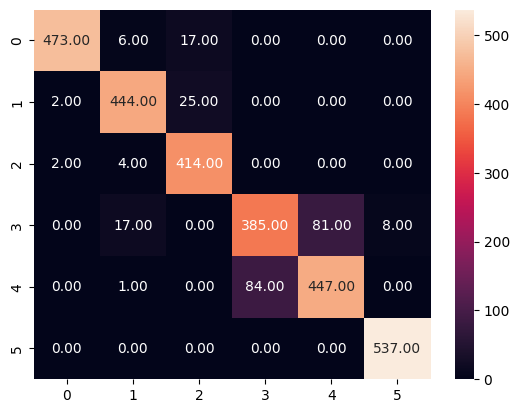

In [8]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
pred=simple_cnn_model.predict([testX,testX,testX,testX])
pred=np.argmax(pred, axis=-1)
cm=confusion_matrix(testy,pred)
print(cm)
print(accuracy_score(testy,pred))
print(classification_report(testy,pred))
sns.heatmap(cm, annot=True, fmt = '.2f')

## LSTM Model

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

# 입력과 출력 설정
input_shape = (128, 9)  # (timesteps, features)
num_classes = 6

# LSTM 모델 정의
lstm_model = Sequential([
    # 첫 번째 LSTM 레이어
    LSTM(128, return_sequences=True, input_shape=input_shape),
    BatchNormalization(),
    Dropout(0.3),

    # 두 번째 LSTM 레이어
    LSTM(64),
    BatchNormalization(),
    Dropout(0.3),

    # 완전연결층
    Dense(64, activation='relu'),
    Dropout(0.3),

    # 출력층
    Dense(num_classes, activation='softmax')
])

# 모델 컴파일
lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 모델 요약 출력
lstm_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128, 128)       │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,382 (489.77 KB)

 Trainable params: 124,998 (488.27 KB)

 Non-trainable params: 384 (1.50 KB)

In [10]:
lstm_history = lstm_model.fit(
    X_train, y_train_one_hot,
    epochs=30,
    batch_size=64,
    validation_data=(X_val, y_val_one_hot)
)


Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 38s 364ms/step - accuracy: 0.5167 - loss: 1.3253 - val_accuracy: 0.4249 - val_loss: 1.4772
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 35s 381ms/step - accuracy: 0.8260 - loss: 0.5063 - val_accuracy: 0.5398 - val_loss: 1.5927
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 33s 358ms/step - accuracy: 0.8935 - loss: 0.2936 - val_accuracy: 0.7090 - val_loss: 1.0235
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 36s 391ms/step - accuracy: 0.9316 - loss: 0.2061 - val_accuracy: 0.9021 - val_loss: 0.3149
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 33s 361ms/step - accuracy: 0.9384 - loss: 0.1686 - val_accuracy: 0.8205 - val_loss: 0.5312
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 361ms/step - accuracy: 0.9206 - loss: 0.2143 - val_accuracy: 0.8273 - val_loss: 0.4222
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 34s 373ms/step - accuracy: 0.9392 - loss: 0.1528 - val_accuracy: 0.9252 - val_loss: 0.1688
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 33s 360ms/step - accuracy: 0.9429 - loss: 0.1415 - val_accu

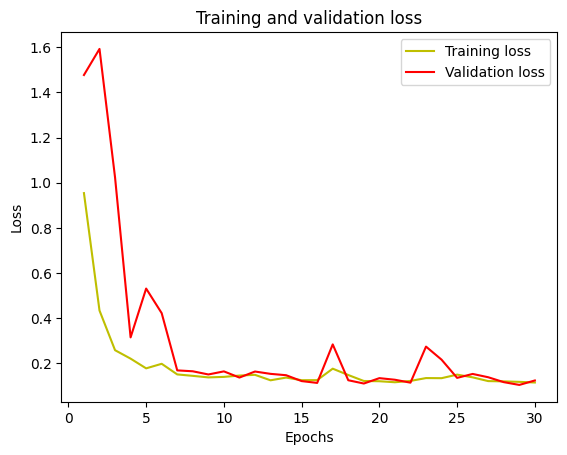

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

loss = lstm_history.history['loss']
val_loss = lstm_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

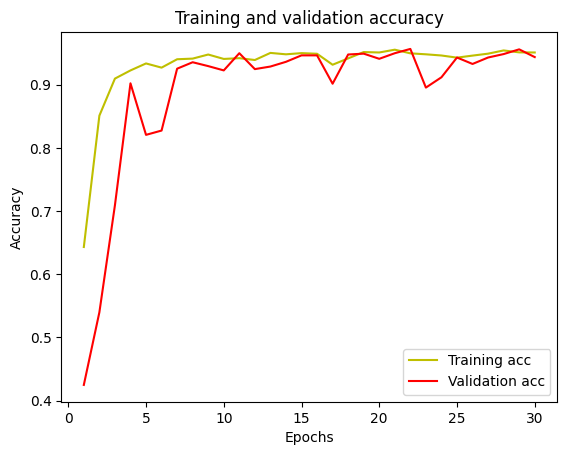

In [12]:
acc = lstm_history.history['accuracy']
val_acc = lstm_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_11
Received: inputs=('Tensor(shape=(32, 128, 9))', 'Tensor(shape=(32, 128, 9))', 'Tensor(shape=(32, 128, 9))', 'Tensor(shape=(32, 128, 9))')
  warnings.warn(msg)


92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_11
Received: inputs=('Tensor(shape=(None, 128, 9))', 'Tensor(shape=(None, 128, 9))', 'Tensor(shape=(None, 128, 9))', 'Tensor(shape=(None, 128, 9))')
  warnings.warn(msg)


93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step
[[490   5   1   0   0   0]
 [  0 463   8   0   0   0]
 [  0  20 400   0   0   0]
 [  0  19   0 370  95   7]
 [  0   1   0  42 489   0]
 [  0   0   0   0   0 537]]
0.9328130302002036
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       496
           1       0.91      0.98      0.95       471
           2       0.98      0.95      0.97       420
           3       0.90      0.75      0.82       491
           4       0.84      0.92      0.88       532
           5       0.99      1.00      0.99       537

    accuracy                           0.93      2947
   macro avg       0.94      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947



<Axes: >

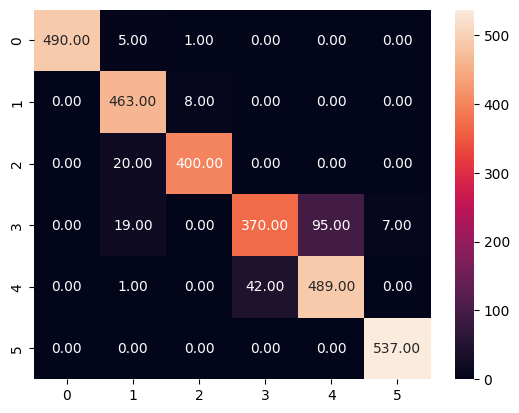

In [13]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
pred=lstm_model.predict([testX,testX,testX,testX])
pred=np.argmax(pred, axis=-1)
cm=confusion_matrix(testy,pred)
print(cm)
print(accuracy_score(testy,pred))
print(classification_report(testy,pred))
sns.heatmap(cm, annot=True, fmt = '.2f')

## GRU Model

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization

# 입력 및 출력 설정
input_shape = (128, 9)
num_classes = 6

# GRU 모델 정의
gru_model = Sequential([
    # 첫 번째 GRU 층
    GRU(128, return_sequences=True, input_shape=input_shape),
    BatchNormalization(),
    Dropout(0.3),

    # 두 번째 GRU 층
    GRU(64),
    BatchNormalization(),
    Dropout(0.3),

    # 완전연결층
    Dense(64, activation='relu'),
    Dropout(0.3),

    # 출력층
    Dense(num_classes, activation='softmax')
])

# 모델 컴파일
gru_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 모델 요약
gru_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 128, 128)       │        53,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,942 (374.77 KB)

 Trainable params: 95,558 (373.27 KB)

 Non-trainable params: 384 (1.50 KB)

In [15]:
gru_history = gru_model.fit(
    X_train, y_train_one_hot,
    epochs=30,
    batch_size=64,
    validation_data=(X_val, y_val_one_hot)
)

Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 42s 397ms/step - accuracy: 0.4751 - loss: 1.3497 - val_accuracy: 0.3453 - val_loss: 1.8331
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 37s 400ms/step - accuracy: 0.7512 - loss: 0.6149 - val_accuracy: 0.4623 - val_loss: 2.3069
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 37s 407ms/step - accuracy: 0.8692 - loss: 0.3561 - val_accuracy: 0.4901 - val_loss: 2.8237
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 36s 389ms/step - accuracy: 0.9270 - loss: 0.2037 - val_accuracy: 0.7192 - val_loss: 0.9377
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 38s 409ms/step - accuracy: 0.9362 - loss: 0.1635 - val_accuracy: 0.9395 - val_loss: 0.1459
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 37s 404ms/step - accuracy: 0.9437 - loss: 0.1477 - val_accuracy: 0.8865 - val_loss: 0.3094
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 35s 384ms/step - accuracy: 0.9468 - loss: 0.1426 - val_accuracy: 0.9150 - val_loss: 0.2129
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 37s 402ms/step - accuracy: 0.9443 - loss: 0.1417 - val_accu

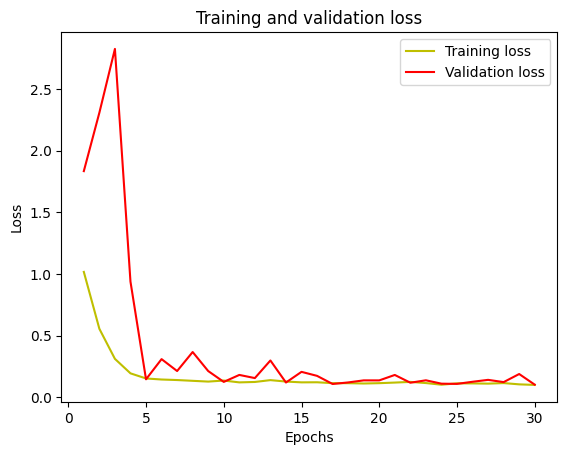

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

loss = gru_history.history['loss']
val_loss = gru_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

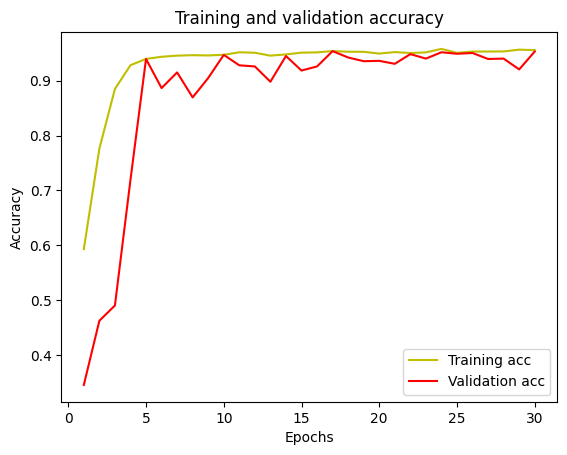

In [17]:
acc = gru_history.history['accuracy']
val_acc = gru_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_21
Received: inputs=('Tensor(shape=(32, 128, 9))', 'Tensor(shape=(32, 128, 9))', 'Tensor(shape=(32, 128, 9))', 'Tensor(shape=(32, 128, 9))')
  warnings.warn(msg)


92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_21
Received: inputs=('Tensor(shape=(None, 128, 9))', 'Tensor(shape=(None, 128, 9))', 'Tensor(shape=(None, 128, 9))', 'Tensor(shape=(None, 128, 9))')
  warnings.warn(msg)


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step
[[479   0  17   0   0   0]
 [  6 430  35   0   0   0]
 [  1   2 417   0   0   0]
 [  0   3   0 393  90   5]
 [  0   0   0  74 458   0]
 [  0   0   0   0   0 537]]
0.9209365456396336
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       496
           1       0.99      0.91      0.95       471
           2       0.89      0.99      0.94       420
           3       0.84      0.80      0.82       491
           4       0.84      0.86      0.85       532
           5       0.99      1.00      1.00       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947



<Axes: >

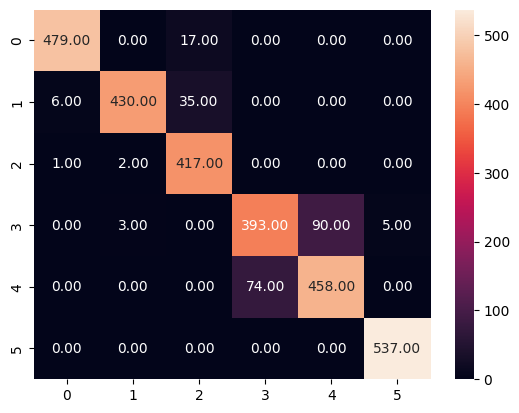

In [18]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
pred=gru_model.predict([testX,testX,testX,testX])
pred=np.argmax(pred, axis=-1)
cm=confusion_matrix(testy,pred)
print(cm)
print(accuracy_score(testy,pred))
print(classification_report(testy,pred))
sns.heatmap(cm, annot=True, fmt = '.2f')

## CNN+LSTM Model

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization

# 입력 및 출력 정의
input_shape = (128, 9)  # (time steps, features)
num_classes = 6

# CNN + LSTM 하이브리드 모델
cnn_lstm_model = Sequential([
    # CNN 블록: 특징 추출
    Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    # LSTM 블록: 시계열 패턴 학습
    LSTM(128, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),

    # Dense 블록
    Dense(64, activation='relu'),
    Dropout(0.3),

    # 출력층
    Dense(num_classes, activation='softmax')
])

# 모델 컴파일
cnn_lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 모델 구조 출력
cnn_lstm_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 126, 64)        │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 126, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,022 (429.77 KB)

 Trainable params: 109,638 (428.27 KB)

 Non-trainable params: 384 (1.50 KB)

In [22]:
cnn_lstm_history = cnn_lstm_model.fit(
    X_train, y_train_one_hot,
    epochs=30,
    batch_size=64,
    validation_data=(X_val, y_val_one_hot)
)

Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 240ms/step - accuracy: 0.9480 - loss: 0.1133 - val_accuracy: 0.9524 - val_loss: 0.0947
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 0.9588 - loss: 0.0962 - val_accuracy: 0.9538 - val_loss: 0.0908
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.9613 - loss: 0.0955 - val_accuracy: 0.9579 - val_loss: 0.0821
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 0.9615 - loss: 0.0855 - val_accuracy: 0.9551 - val_loss: 0.1034
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - accuracy: 0.9551 - loss: 0.1061 - val_accuracy: 0.9606 - val_loss: 0.0828
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - accuracy: 0.9633 - loss: 0.0853 - val_accuracy: 0.9483 - val_loss: 0.1052
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.9562 - loss: 0.0916 - val_accuracy: 0.9592 - val_loss: 0.0830
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.9591 - loss: 0.0882 - val_accu

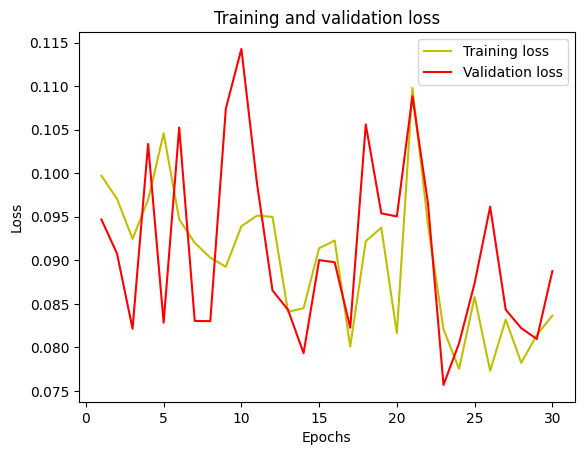

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

loss = cnn_lstm_history.history['loss']
val_loss = cnn_lstm_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

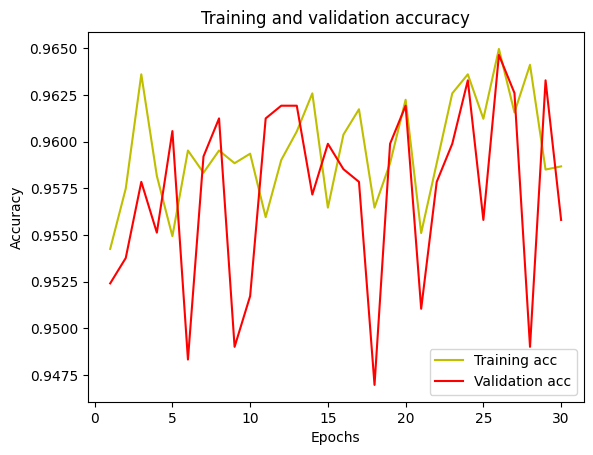

In [24]:
acc = cnn_lstm_history.history['accuracy']
val_acc = cnn_lstm_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_31
Received: inputs=('Tensor(shape=(32, 128, 9))', 'Tensor(shape=(32, 128, 9))', 'Tensor(shape=(32, 128, 9))', 'Tensor(shape=(32, 128, 9))')
  warnings.warn(msg)


92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_31
Received: inputs=('Tensor(shape=(None, 128, 9))', 'Tensor(shape=(None, 128, 9))', 'Tensor(shape=(None, 128, 9))', 'Tensor(shape=(None, 128, 9))')
  warnings.warn(msg)


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step
[[487   1   8   0   0   0]
 [  4 465   1   1   0   0]
 [  0   1 418   0   1   0]
 [  0   4   0 416  68   3]
 [  0   0   0  75 457   0]
 [  0   0   0   0   0 537]]
0.9433322022395657
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       496
           1       0.99      0.99      0.99       471
           2       0.98      1.00      0.99       420
           3       0.85      0.85      0.85       491
           4       0.87      0.86      0.86       532
           5       0.99      1.00      1.00       537

    accuracy                           0.94      2947
   macro avg       0.94      0.95      0.94      2947
weighted avg       0.94      0.94      0.94      2947



<Axes: >

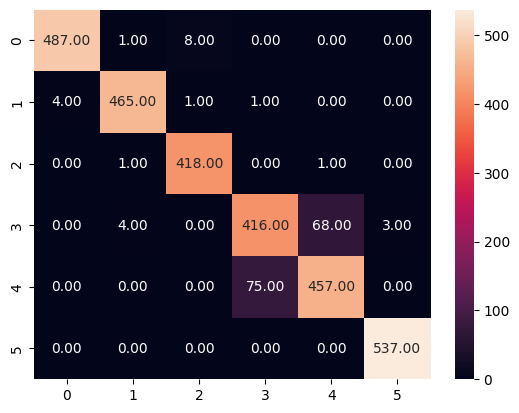

In [25]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
pred=cnn_lstm_model.predict([testX,testX,testX,testX])
pred=np.argmax(pred, axis=-1)
cm=confusion_matrix(testy,pred)
print(cm)
print(accuracy_score(testy,pred))
print(classification_report(testy,pred))
sns.heatmap(cm, annot=True, fmt = '.2f')

## CNN+GRU Model

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Dropout, BatchNormalization

# 입력 및 출력 설정
input_shape = (128, 9)
num_classes = 6

# CNN + GRU 하이브리드 모델 정의
cnn_gru_model = Sequential([
    # CNN 블록: 로컬 특징 추출
    Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    # GRU 블록: 시계열 패턴 학습
    GRU(128, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),

    # Dense 블록
    Dense(64, activation='relu'),
    Dropout(0.3),

    # 출력층
    Dense(num_classes, activation='softmax')
])

# 모델 컴파일
cnn_gru_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 모델 구조 요약
cnn_gru_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 126, 64)        │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 126, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 128)            │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,702 (334.77 KB)

 Trainable params: 85,318 (333.27 KB)

 Non-trainable params: 384 (1.50 KB)

In [27]:
cnn_gru_history = cnn_gru_model.fit(
    X_train, y_train_one_hot,
    epochs=30,
    batch_size=64,
    validation_data=(X_val, y_val_one_hot)
)

Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 153ms/step - accuracy: 0.5635 - loss: 1.2019 - val_accuracy: 0.3821 - val_loss: 1.5347
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 0.8707 - loss: 0.3592 - val_accuracy: 0.4596 - val_loss: 2.7543
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 0.9319 - loss: 0.1853 - val_accuracy: 0.8375 - val_loss: 0.6208
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 0.9371 - loss: 0.1627 - val_accuracy: 0.8681 - val_loss: 0.5290
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 0.9412 - loss: 0.1570 - val_accuracy: 0.9313 - val_loss: 0.1588
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - accuracy: 0.9386 - loss: 0.1567 - val_accuracy: 0.9409 - val_loss: 0.1225
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 0.9490 - loss: 0.1236 - val_accuracy: 0.9422 - val_loss: 0.1253
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - accuracy: 0.9470 - loss: 0.1257 - val_accu

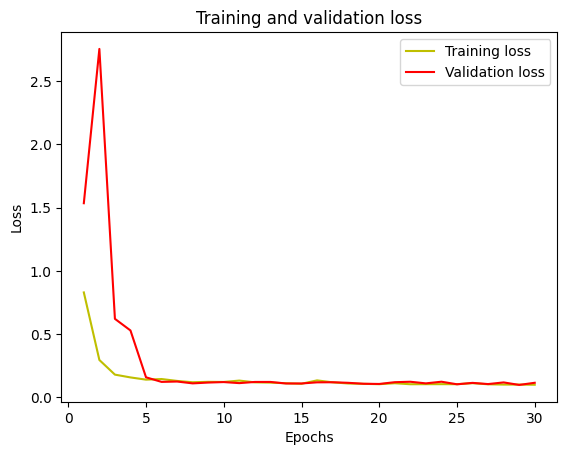

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

loss = cnn_gru_history.history['loss']
val_loss = cnn_gru_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

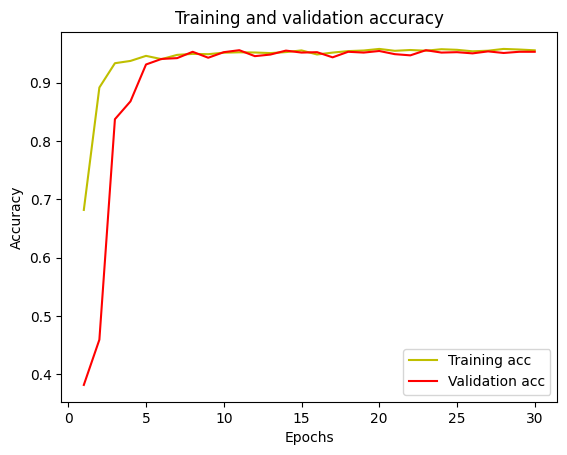

In [29]:
acc = cnn_gru_history.history['accuracy']
val_acc = cnn_gru_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_42
Received: inputs=('Tensor(shape=(32, 128, 9))', 'Tensor(shape=(32, 128, 9))', 'Tensor(shape=(32, 128, 9))', 'Tensor(shape=(32, 128, 9))')
  warnings.warn(msg)


91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_42
Received: inputs=('Tensor(shape=(None, 128, 9))', 'Tensor(shape=(None, 128, 9))', 'Tensor(shape=(None, 128, 9))', 'Tensor(shape=(None, 128, 9))')
  warnings.warn(msg)


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
[[482   0  14   0   0   0]
 [  1 448  22   0   0   0]
 [  1   3 416   0   0   0]
 [  0   3   0 384  98   6]
 [  0   0   0  61 471   0]
 [  0   0   0   0   0 537]]
0.9290804207668816
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       496
           1       0.99      0.95      0.97       471
           2       0.92      0.99      0.95       420
           3       0.86      0.78      0.82       491
           4       0.83      0.89      0.86       532
           5       0.99      1.00      0.99       537

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947



<Axes: >

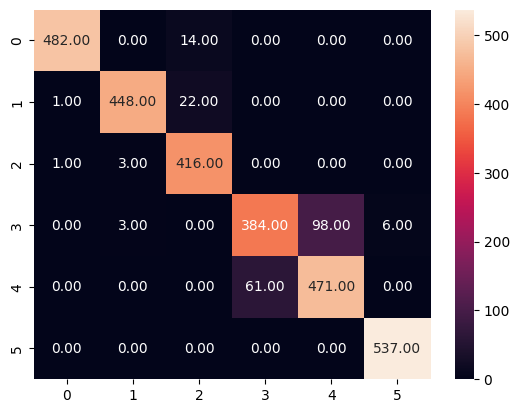

In [30]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
pred=cnn_gru_model.predict([testX,testX,testX,testX])
pred=np.argmax(pred, axis=-1)
cm=confusion_matrix(testy,pred)
print(cm)
print(accuracy_score(testy,pred))
print(classification_report(testy,pred))
sns.heatmap(cm, annot=True, fmt = '.2f')